In [1]:
import json
import math
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

!plotly_get_chrome -y

Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /opt/conda/lib/python3.13/site-packages/choreographer/cli/browser_exe/chrome-linux64/chrome


In [2]:
# --- Configurações do Pandas ---
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# --- Configurações de Avisos ---
warnings.filterwarnings('ignore')

# --- Configurações do Plotly ---
pio.templates.default = "plotly_white"
pio.templates[pio.templates.default].layout.font = dict(
    family="Arial, sans-serif",
    size=16,
    color="black"
)

# --- Definição de Diretórios e Arquivos ---
DATA_DIR = Path(".")
OUTPUT_DIR = DATA_DIR / "imagens"
CONFIG_FILE = DATA_DIR / "config.json"
RESULTS_FILE = DATA_DIR / "simulation_results.csv"
VIZ_FILE = DATA_DIR / "visualization_data.csv"
NN_RESULTS_FILE = DATA_DIR / "nn_validation_results.csv"

# Cria diretório de imagens se não existir
if not OUTPUT_DIR.exists():
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Diretório '{OUTPUT_DIR}' criado.")

# --- Carregamento de Configuração Global ---
try:
    with open(CONFIG_FILE, 'r') as f:
        CONFIG = json.load(f)
    print("Configuração carregada com sucesso.")
except FileNotFoundError:
    print("AVISO: 'config.json' não encontrado. Usando valores padrão.")
    CONFIG = {
        "total_area_km2": 53.0, 
        "bounds": {"min_lat": 51.15, "max_lat": 51.35, "min_lon": 4.20, "max_lon": 4.60}
    }

TOTAL_AREA_M2 = CONFIG.get('total_area_km2', 53.0) * 1e6
BOUNDS = CONFIG.get('bounds')

Configuração carregada com sucesso.


In [3]:
def exportar_e_exibir(fig, nome_arquivo, titulo_exibicao, height=600):
    """
    Aplica a regra de negócio: Salvar PNG limpo (sem título) e exibir interativo com título.
    """
    # 1. Remover título para salvar
    fig.update_layout(title_text=None, height=height)
    
    # 2. Salvar em Alta Resolução (scale=3 ~ 300 DPI)
    caminho = OUTPUT_DIR / nome_arquivo
    try:
        fig.write_image(caminho, scale=3)
        print(f"[Salvo] {caminho}")
    except Exception as e:
        print(f"[Erro ao Salvar] {e}")

    # 3. Adicionar título e exibir
    fig.update_layout(title_text=titulo_exibicao)
    fig.show()

def haversine(lat1, lon1, lat2, lon2):
    """Calcula distância em metros entre coordenadas."""
    R = 6371000
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def preparar_dados_erro(df_sim, df_nn_path):
    """Combina resultados de simulação com resultados da Rede Neural."""
    # Formato Longo (Melt) para Plotly
    df_melted = df_sim.melt(var_name='Algoritmo', value_name='Erro (metros)').dropna()
    
    # Tenta carregar e anexar dados da NN
    if df_nn_path.exists():
        try:
            df_nn = pd.read_csv(df_nn_path)
            df_nn_formatted = pd.DataFrame({
                'Algoritmo': 'NN_LoRa_GT',
                'Erro (metros)': df_nn['error']
            }).dropna()
            df_final = pd.concat([df_melted, df_nn_formatted], ignore_index=True)
            print("Dados da Rede Neural integrados.")
            return df_final
        except Exception as e:
            print(f"Erro ao processar NN: {e}")
    
    return df_melted

In [4]:
# 1. Carga de Dados Principais
if RESULTS_FILE.exists():
    df_results = pd.read_csv(RESULTS_FILE)
    print(f"Resultados carregados: {df_results.shape}")
else:
    df_results = pd.DataFrame()
    print("ERRO CRÍTICO: Arquivo de resultados não encontrado.")

# 2. Cálculo de Erros Relativos
df_relative = pd.DataFrame()
if not df_results.empty:
    for col in df_results.columns:
        # Área do círculo de erro / Área total
        df_relative[col] = (np.pi * df_results[col]**2) / TOTAL_AREA_M2 * 100

# 3. Preparação para Gráficos (Melt + Merge NN)
df_viz_errors = preparar_dados_erro(df_results, NN_RESULTS_FILE)

# 4. Carga de Dados Geográficos (COM CORREÇÃO DE DATA)
if VIZ_FILE.exists():
    df_geo = pd.read_csv(VIZ_FILE)
    
    # Parse de datas robusto
    if 'timestamp' in df_geo.columns:
        # A correção principal está aqui: format='mixed' lida com variações no formato
        df_geo['timestamp'] = pd.to_datetime(df_geo['timestamp'], format='mixed', utc=True)
        
    print(f"Dados geográficos carregados: {df_geo.shape}")
else:
    df_geo = pd.DataFrame()

Resultados carregados: (53419, 9)
Erro ao processar NN: 'error'
Dados geográficos carregados: (53419, 24)


In [5]:
if not df_results.empty:
    print("--- Estatísticas: Erro Absoluto (m) ---")
    display(df_results.describe())
    
    print("\n--- Estatísticas: Erro Relativo à Área (%) ---")
    display(df_relative.describe())

--- Estatísticas: Erro Absoluto (m) ---


WCL   MLAT-LSE    TDoA-LM  TDoA-RANSAC  WCL+Kalman  \
count 48035.0000 27774.0000 24997.0000   14303.0000  47932.0000   
mean    518.6671  1703.8934   440.2182     425.7659    449.3545   
std     460.4953  1048.4133   483.4335     511.3815    367.8332   
min       1.0066     2.1210     1.7137       3.1736      2.0451   
25%     180.6710   892.9660   166.0905     156.4742    176.6836   
50%     374.2438  1509.4136   296.2664     275.0845    334.2373   
75%     712.8057  2320.8667   532.6691     494.8983    613.0447   
max    5860.5375  7671.3696  7259.8895    7575.0445   5410.9007   

       MLAT-LSE+Kalman  TDoA-LM+Kalman       ARFL  TDoA-RANSAC+Kalman  
count       27640.0000      24942.0000 20253.0000          14254.0000  
mean         1386.6553        377.9549   423.4208            386.1259  
std           846.8488        351.3194   317.7778            419.1410  
min             5.1147          2.3694     1.7281              2.4399  
25%           741.9243        163.3731   204.7510            152.9346  
50%          1224.9849        284.0747   349.1442            269.1735  
75%          1870.6525        477.2150   556.9055            467.8249  
max          6822.9039       6085.4134  3954.1863           7130.3810


--- Estatísticas: Erro Relativo à Área (%) ---


WCL   MLAT-LSE    TDoA-LM  TDoA-RANSAC  WCL+Kalman  \
count 48035.0000 27774.0000 24997.0000   14303.0000  47932.0000   
mean      2.8478    23.6930     2.5306       2.6211      1.9962   
std       6.2858    28.6392     9.2838      11.4702      3.8392   
min       0.0000     0.0000     0.0000       0.0001      0.0000   
25%       0.1932     4.7203     0.1633       0.1449      0.1848   
50%       0.8291    13.4871     0.5196       0.4480      0.6613   
75%       3.0078    31.8861     1.6796       1.4499      2.2248   
max     203.3179   348.3747   312.0045     339.6809    173.3165   

       MLAT-LSE+Kalman  TDoA-LM+Kalman       ARFL  TDoA-RANSAC+Kalman  
count       27640.0000      24942.0000 20253.0000          14254.0000  
mean           15.6277          1.5762     1.6591              1.9225  
std            19.3498          5.0107     3.2049              7.4226  
min             0.0002          0.0000     0.0000              0.0000  
25%             3.2585          0.1580     0.2482              0.1385  
50%             8.8831          0.4777     0.7216              0.4289  
75%            20.7151          1.3481     1.8360              1.2956  
max           275.5747        219.2204    92.5582            300.9721

In [6]:
# --- Configuração da Análise ---
if not df_results.empty:
    print("\n--- Gerando Tabela LaTeX ---")

    # 1. Cálculo do Erro Relativo (%)
    df_rel = pd.DataFrame()
    for col in df_results.columns:
        df_rel[col] = (math.pi * df_results[col]**2) / TOTAL_AREA_M2 * 100

    # 2. Mapeamento de Nomes
    nome_map = {
        'WCL': 'WCL (Centroide ponderado)',
        'WCL+Kalman': 'WCL+Kalman',
        'MLAT-LSE': 'MLAT-LSE',
        'MLAT-LSE+Kalman': 'MLAT-LSE+Kalman',
        'TDoA-LM': 'TDoA-LM',
        'TDoA-LM+Kalman': 'TDoA-LM+Kalman',
        'TDoA-RANSAC': 'TDoA-RANSAC',
        'TDoA-RANSAC+Kalman': 'TDoA-RANSAC+Kalman',
        'ARFL': 'ARFL (Fusão WCL + TDoA-LM)',
        'NN_LoRa_GT': 'Rede Neural (NN_LoRa_GT)'
    }

    # 3. Ordem de Exibição
    ordem_exibicao = [
        'WCL', 'WCL+Kalman', 'MLAT-LSE', 'MLAT-LSE+Kalman',
        'TDoA-LM', 'TDoA-LM+Kalman', 'TDoA-RANSAC', 'TDoA-RANSAC+Kalman',
        'ARFL', 'NN_LoRa_GT'
    ]

    # Função de formatação (float -> string pt-BR)
    def fmt(val):
        if pd.isna(val): return "-"
        return "{:.2f}".format(val).replace('.', ',')

    rows_latex = []
    
    # Filtra algoritmos existentes
    algoritmos_presentes = [alg for alg in ordem_exibicao if alg in df_results.columns]

    for alg in algoritmos_presentes:
        # --- Dados Absolutos ---
        series_abs = df_results[alg]
        
        # Estatísticas Absolutas
        abs_mean = series_abs.mean()
        abs_med = series_abs.median()
        abs_max = series_abs.max()
        abs_min = series_abs.min()
        
        # --- DEFINIÇÃO SOLICITADA: ZERAR REMOVIDOS ---
        pct_removidos = 0.0 

        # --- Dados Relativos ---
        series_rel = df_rel[alg]
        rel_mean = series_rel.mean()
        rel_med = series_rel.median()
        rel_max = series_rel.max()
        rel_min = series_rel.min()

        nome_display = nome_map.get(alg, alg)

        # Montagem da linha LaTeX
        # Estrutura: Nome & Abs(Mean, Med, Max, Min, Rem) & (Espaço) & Rel(Mean, Med, Max, Min, Rem) \\
        linha = (
            f"{nome_display} & "
            f"{fmt(abs_mean)} & {fmt(abs_med)} & {fmt(abs_max)} & {fmt(abs_min)} & {fmt(pct_removidos)} & & "
            f"{fmt(rel_mean)} & {fmt(rel_med)} & {fmt(rel_max)} & {fmt(rel_min)} & {fmt(pct_removidos)} \\\\"
        )
        
        rows_latex.append(linha)

        # Adiciona separadores visuais
        if alg == 'MLAT-LSE+Kalman' or alg == 'TDoA-RANSAC+Kalman':
            rows_latex.append(r"\midrule")

    corpo_tabela = "\n            ".join(rows_latex)

    # 4. Template LaTeX Final
    latex_code = fr"""
\begin{{table}}[h]
    % Configuração da largura da legenda para igualar à tabela
    \captionsetup{{width=0.83\textwidth}}
    \centering
    \caption{{\label{{tab:resultados}}Métricas de desempenho dos algoritmos de localização.}}
    \begin{{tabular}}{{p{{6cm}} ccccclccccc}}\toprule
        & \multicolumn{{5}}{{c}}{{\textbf{{Erro absoluto (m)}}}}& & \multicolumn{{5}}{{c}}{{\textbf{{Erro relativo (\%)}}}}\\ \midrule
        \multicolumn{{1}}{{c}}{{\textbf{{Método}}}} & \textbf{{Média}} & \textbf{{Mediana}}  & \textbf{{Max.}}&\textbf{{Min}}. &\textbf{{\% Remov.}}&& \textbf{{Média}} & \textbf{{Mediana}}  & \textbf{{Max.}}& \textbf{{Min}}. &\textbf{{\% Remov.}}\\ \midrule
            {corpo_tabela} \bottomrule
    \end{{tabular}}
    \fonte{{Autoria própria}}
\end{{table}}
"""
    print("-" * 30)
    print(latex_code)
    print("-" * 30)

else:
    print("Erro: 'df_results' vazio. Execute a simulação primeiro.")


--- Gerando Tabela LaTeX ---
------------------------------

\begin{table}[h]
    % Configuração da largura da legenda para igualar à tabela
    \captionsetup{width=0.83\textwidth}
    \centering
    \caption{\label{tab:resultados}Métricas de desempenho dos algoritmos de localização.}
    \begin{tabular}{p{6cm} ccccclccccc}\toprule
        & \multicolumn{5}{c}{\textbf{Erro absoluto (m)}}& & \multicolumn{5}{c}{\textbf{Erro relativo (\%)}}\\ \midrule
        \multicolumn{1}{c}{\textbf{Método}} & \textbf{Média} & \textbf{Mediana}  & \textbf{Max.}&\textbf{Min}. &\textbf{\% Remov.}&& \textbf{Média} & \textbf{Mediana}  & \textbf{Max.}& \textbf{Min}. &\textbf{\% Remov.}\\ \midrule
            WCL (Centroide ponderado) & 518,67 & 374,24 & 5860,54 & 1,01 & 0,00 & & 2,85 & 0,83 & 203,32 & 0,00 & 0,00 \\
            WCL+Kalman & 449,35 & 334,24 & 5410,90 & 2,05 & 0,00 & & 2,00 & 0,66 & 173,32 & 0,00 & 0,00 \\
            MLAT-LSE & 1703,89 & 1509,41 & 7671,37 & 2,12 & 0,00 & & 23,69 & 13,49 & 34

[Salvo] imagens/cdf_rssi_nn.png


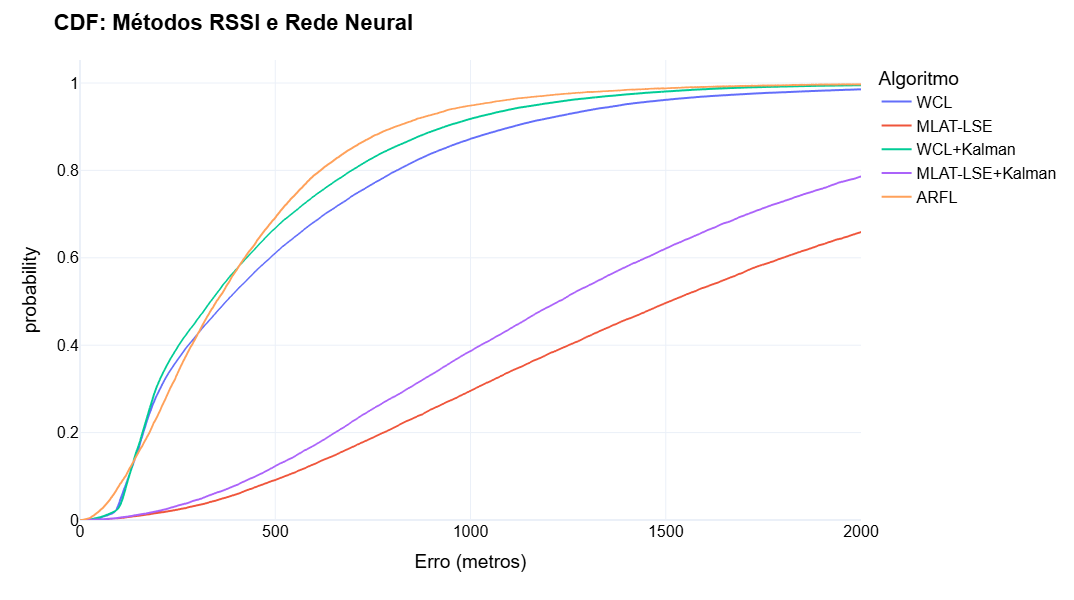

[Salvo] imagens/cdf_tdoa.png


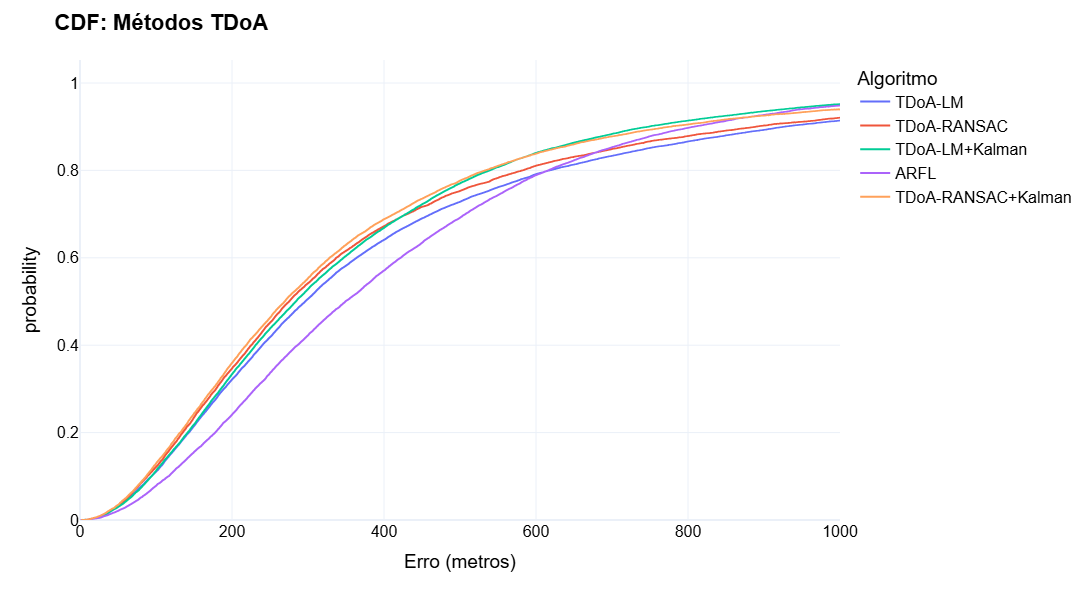

In [ ]:
if not df_viz_errors.empty:
    # --- Configurações de Grupos ---
    grupos_plotagem = {
        "RSSI_NN": {
            "filtros": ['WCL', 'WCL+Kalman', 'MLAT-LSE', 'MLAT-LSE+Kalman', 'ARFL', 'NN_LoRa_GT'],
            "titulo": "<b>CDF: Métodos RSSI e Rede Neural</b>",
            "arquivo": "cdf_rssi_nn.png",
            "range_x": [0, 2000]
        },
        "TDoA": {
            "filtros": ['TDoA-LM', 'TDoA-LM+Kalman', 'TDoA-RANSAC', 'TDoA-RANSAC+Kalman', 'ARFL'],
            "titulo": "<b>CDF: Métodos TDoA</b>",
            "arquivo": "cdf_tdoa.png",
            "range_x": [0, 1000]
        },
        "Melhores": {
            "filtros": ['TDoA-LM+Kalman', 'TDoA-RANSAC+Kalman', 'WCL+Kalman', 'ARFL'],
            "titulo": "<b>CDF: Comparativo dos Melhores Métodos (Fusão)</b>",
            "arquivo": "cdf_best_methods.png",
            "range_x": [0, 1000]
        }
    }

    # --- Loop de Geração de Gráficos ---
    for key, config in grupos_plotagem.items():
        df_filtered = df_viz_errors[df_viz_errors['Algoritmo'].isin(config['filtros'])]
        
        if not df_filtered.empty:
            fig = px.ecdf(
                df_filtered,
                x='Erro (metros)',
                color='Algoritmo',
                labels={'value': 'Proporção Acumulada'}
            )
            fig.update_xaxes(range=config['range_x'])
            exportar_e_exibir(fig, config['arquivo'], config['titulo'])

In [ ]:
if not df_geo.empty:
    # Contagem de colunas de estimativa (excluindo Ground Truth)
    counts = df_geo.filter(like='_x').count()
    if 'gt_x' in counts:
        counts = counts.drop('gt_x')
    
    # Limpeza dos nomes
    counts.index = counts.index.str.replace('_x', '')
    # Remove variantes '+Kalman' para simplificar visualização de disponibilidade pura
    counts = counts[~counts.index.str.contains(r"\+Kalman")].sort_values(ascending=False)

    fig_bar = px.bar(
        x=counts.index,
        y=counts.values,
        labels={'x': 'Método', 'y': 'Pacotes Válidos'},
        text_auto=True
    )
    
    exportar_e_exibir(fig_bar, "contagem_pacotes.png", "<b>Disponibilidade de Estimativas por Método</b>")

In [ ]:
if not df_geo.empty and BOUNDS:
    # --- Configuração dos Nós Alvos ---
    target_ids = ['3432333857376218', '343233385F377C18', '3432333864377C18']
    
    # --- Preparação do Polígono da Área ---
    poly_coords = [
        (BOUNDS['min_lon'], BOUNDS['min_lat']),
        (BOUNDS['min_lon'], BOUNDS['max_lat']),
        (BOUNDS['max_lon'], BOUNDS['max_lat']),
        (BOUNDS['max_lon'], BOUNDS['min_lat']),
        (BOUNDS['min_lon'], BOUNDS['min_lat']) # Fechar loop
    ]
    
    # --- Mapa 1: Trilhas (Ground Truth) ---
    # --- Filtragem dos Dados ---
    # Filtra linhas válidas, ordena por tempo e seleciona APENAS os IDs alvos
    df_tracks = df_geo.dropna(subset=['gt_lat', 'gt_lon']).sort_values('timestamp')
    df_tracks = df_tracks[df_tracks['dev_id'].isin(target_ids)]
    
    fig_map = px.line_map(
        df_tracks,
        lat="gt_lat", lon="gt_lon",
        color="dev_id",
        zoom=10,
        labels={'dev_id': 'ID do nó alvo'}
    )
    
    # Adiciona retângulo da área
    fig_map.update_layout(
        map_style="carto-positron",
        map_layers=[{
            "source": gpd.GeoDataFrame(geometry=[Polygon(poly_coords)]).__geo_interface__,
            "type": "line", "color": "blue", "line": {"width": 2}
        }]
    )
    
    exportar_e_exibir(fig_map, "mapa_trilhas.png", "<b>Trilhas (Ground Truth) e Área de Cobertura</b>", height=400)

    # --- Mapa 2: Heatmap de Densidade ---
    df_tracks = df_geo.dropna(subset=['gt_lat', 'gt_lon']).sort_values('timestamp')
    fig_heat = go.Figure()
    
    # Camada Heatmap
    fig_heat.add_trace(go.Densitymapbox(
        lat=df_tracks['gt_lat'],
        lon=df_tracks['gt_lon'],
        radius=5,
        colorscale="Jet",
        showscale=True
    ))
    
    # Camada Borda (Scattermapbox para linhas no graph_objects)
    lons_b, lats_b = zip(*poly_coords)
    fig_heat.add_trace(go.Scattermapbox(
        lat=lats_b, lon=lons_b,
        mode='lines',
        line=dict(width=3, color='black'),
        showlegend=False
    ))
    
    fig_heat.update_layout(
        mapbox_style="carto-positron",
        mapbox_zoom=11,
        mapbox_center={"lat": np.mean([BOUNDS['min_lat'], BOUNDS['max_lat']]), 
                       "lon": np.mean([BOUNDS['min_lon'], BOUNDS['max_lon']])}
    )
    
    exportar_e_exibir(fig_heat, "heatmap_densidade.png", "<b>Densidade de Pontos (Heatmap)</b>", height=700)

In [ ]:
# --- Configuração dos Algoritmos a Plotar ---
algoritmos_para_plotar = [
    {
        "nome": "TDoA-RANSAC+Kalman",
        "titulo": "<b>Densidade de Estimativas: TDoA-RANSAC+Kalman</b>",
        "arquivo": "heatmap_tdoa_ransac_kalman.png"
    },
    {
        "nome": "WCL+Kalman",
        "titulo": "<b>Densidade de Estimativas: WCL+Kalman</b>",
        "arquivo": "heatmap_wcl_kalman.png"
    }
]

# --- Loop de Processamento ---
if not df_geo.empty:
    print("--- Gerando Heatmaps de Densidade ---")
    
    for config in algoritmos_para_plotar:
        alg_nome = config["nome"]
        
        # Verifica se as colunas existem
        col_x, col_y = f'{alg_nome}_x', f'{alg_nome}_y'
        
        if col_x in df_geo.columns and col_y in df_geo.columns:
            # 1. Filtragem
            cols_necessarias = [col_x, col_y, 'gt_lat', 'gt_lon', 'gt_x', 'gt_y']
            df_heatmap = df_geo.dropna(subset=cols_necessarias).copy()
            
            if not df_heatmap.empty:
                # 2. Conversão Cartesiano (X,Y) -> Geográfico (Lat,Lon)
                # Usando Ground Truth como referência diferencial
                R_TERRA = 6371000
                
                dx = df_heatmap[col_x] - df_heatmap['gt_x']
                dy = df_heatmap[col_y] - df_heatmap['gt_y']
                
                df_heatmap['est_lat'] = df_heatmap['gt_lat'] + np.degrees(dy / R_TERRA)
                df_heatmap['est_lon'] = df_heatmap['gt_lon'] + np.degrees(dx / (R_TERRA * np.cos(np.radians(df_heatmap['gt_lat']))))
                
                # 3. Construção do Gráfico
                fig_heat = go.Figure()

                # Camada: Heatmap
                fig_heat.add_trace(go.Densitymapbox(
                    lat=df_heatmap['est_lat'],
                    lon=df_heatmap['est_lon'],
                    radius=4,
                    colorscale="Jet",
                    opacity=0.7,
                    showscale=True,
                    hoverinfo='skip'
                ))

                # Camada: Borda da Área
                if BOUNDS:
                    poly_coords = [
                        (BOUNDS['min_lon'], BOUNDS['min_lat']),
                        (BOUNDS['min_lon'], BOUNDS['max_lat']),
                        (BOUNDS['max_lon'], BOUNDS['max_lat']),
                        (BOUNDS['max_lon'], BOUNDS['min_lat']),
                        (BOUNDS['min_lon'], BOUNDS['min_lat'])
                    ]
                    lons_b, lats_b = zip(*poly_coords)
                    
                    fig_heat.add_trace(go.Scattermapbox(
                        lat=lats_b, lon=lons_b,
                        mode='lines',
                        line=dict(width=3, color='black'),
                        showlegend=False
                    ))

                # 4. Layout
                lat_center = np.mean([BOUNDS['min_lat'], BOUNDS['max_lat']]) if BOUNDS else df_heatmap['est_lat'].mean()
                lon_center = np.mean([BOUNDS['min_lon'], BOUNDS['max_lon']]) if BOUNDS else df_heatmap['est_lon'].mean()

                fig_heat.update_layout(
                    mapbox_style="carto-positron",
                    mapbox_zoom=11,
                    mapbox_center={"lat": lat_center, "lon": lon_center},
                    margin={"r":0,"t":30,"l":0,"b":0}
                )

                # 5. Exportar e Exibir
                exportar_e_exibir(fig_heat, config["arquivo"], config["titulo"], height=700)
                
            else:
                print(f"Aviso: Sem dados válidos para {alg_nome}.")
        else:
            print(f"Ignorado: Colunas para {alg_nome} não encontradas.")
else:
    print("Erro: DataFrame geográfico vazio.")